In [83]:
import matplotlib
matplotlib.use('Agg')

import collections
import numpy as np
import os
import h5py
from scipy.stats import zscore
import pyret.filtertools as ft
import pyret.spiketools as sp
import pyret.stimulustools as st
from deepretina.toolbox import load_model, load_partial_model, rolling_window
from deepretina.io import despine
from deepretina.metrics import cc
from scipy.interpolate import interp1d
from scipy.signal import detrend

from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

plt.style.use('deepretina')

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'seismic'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [16]:
data_dir = os.path.expanduser('~/data/kastner/')
h_file = 'horizontals.h5'
a_file = 'amacrines.h5'

# Horizontal cells

In [79]:
h_rfs = collections.defaultdict(list)
h_recreated_rfs = collections.defaultdict(list)
with h5py.File(data_dir + h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        h_rfs[expt] = np.array(f['lines/rfs/%s' %expt])
        detrended_mem_pot = np.array(f['lines/detrended_membrane_potential'])[ide]
        stimuli = np.array(f['lines/stimuli'])
        h_recreated_rf = np.zeros_like(h_rfs[expt])
        window_size = h_rfs[expt].shape[0]
        for t in range(window_size, len(detrended_mem_pot)):
            h_recreated_rf += stimuli[(t-window_size):t].astype('float') * detrended_mem_pot[t]
        h_recreated_rf /= (len(detrended_mem_pot) - window_size)
        h_recreated_rfs[expt] = h_recreated_rf[::-1]

In [80]:
expts = sorted(rfs.keys())
expts

['011812_c1',
 '020612_c2',
 '090312_r1_c1',
 '092312_r1_c1',
 '092312_r3_c1',
 '120212_r1_c1',
 '121612_r2_c1',
 '122412_r1_c1',
 '122412_r2_c1']

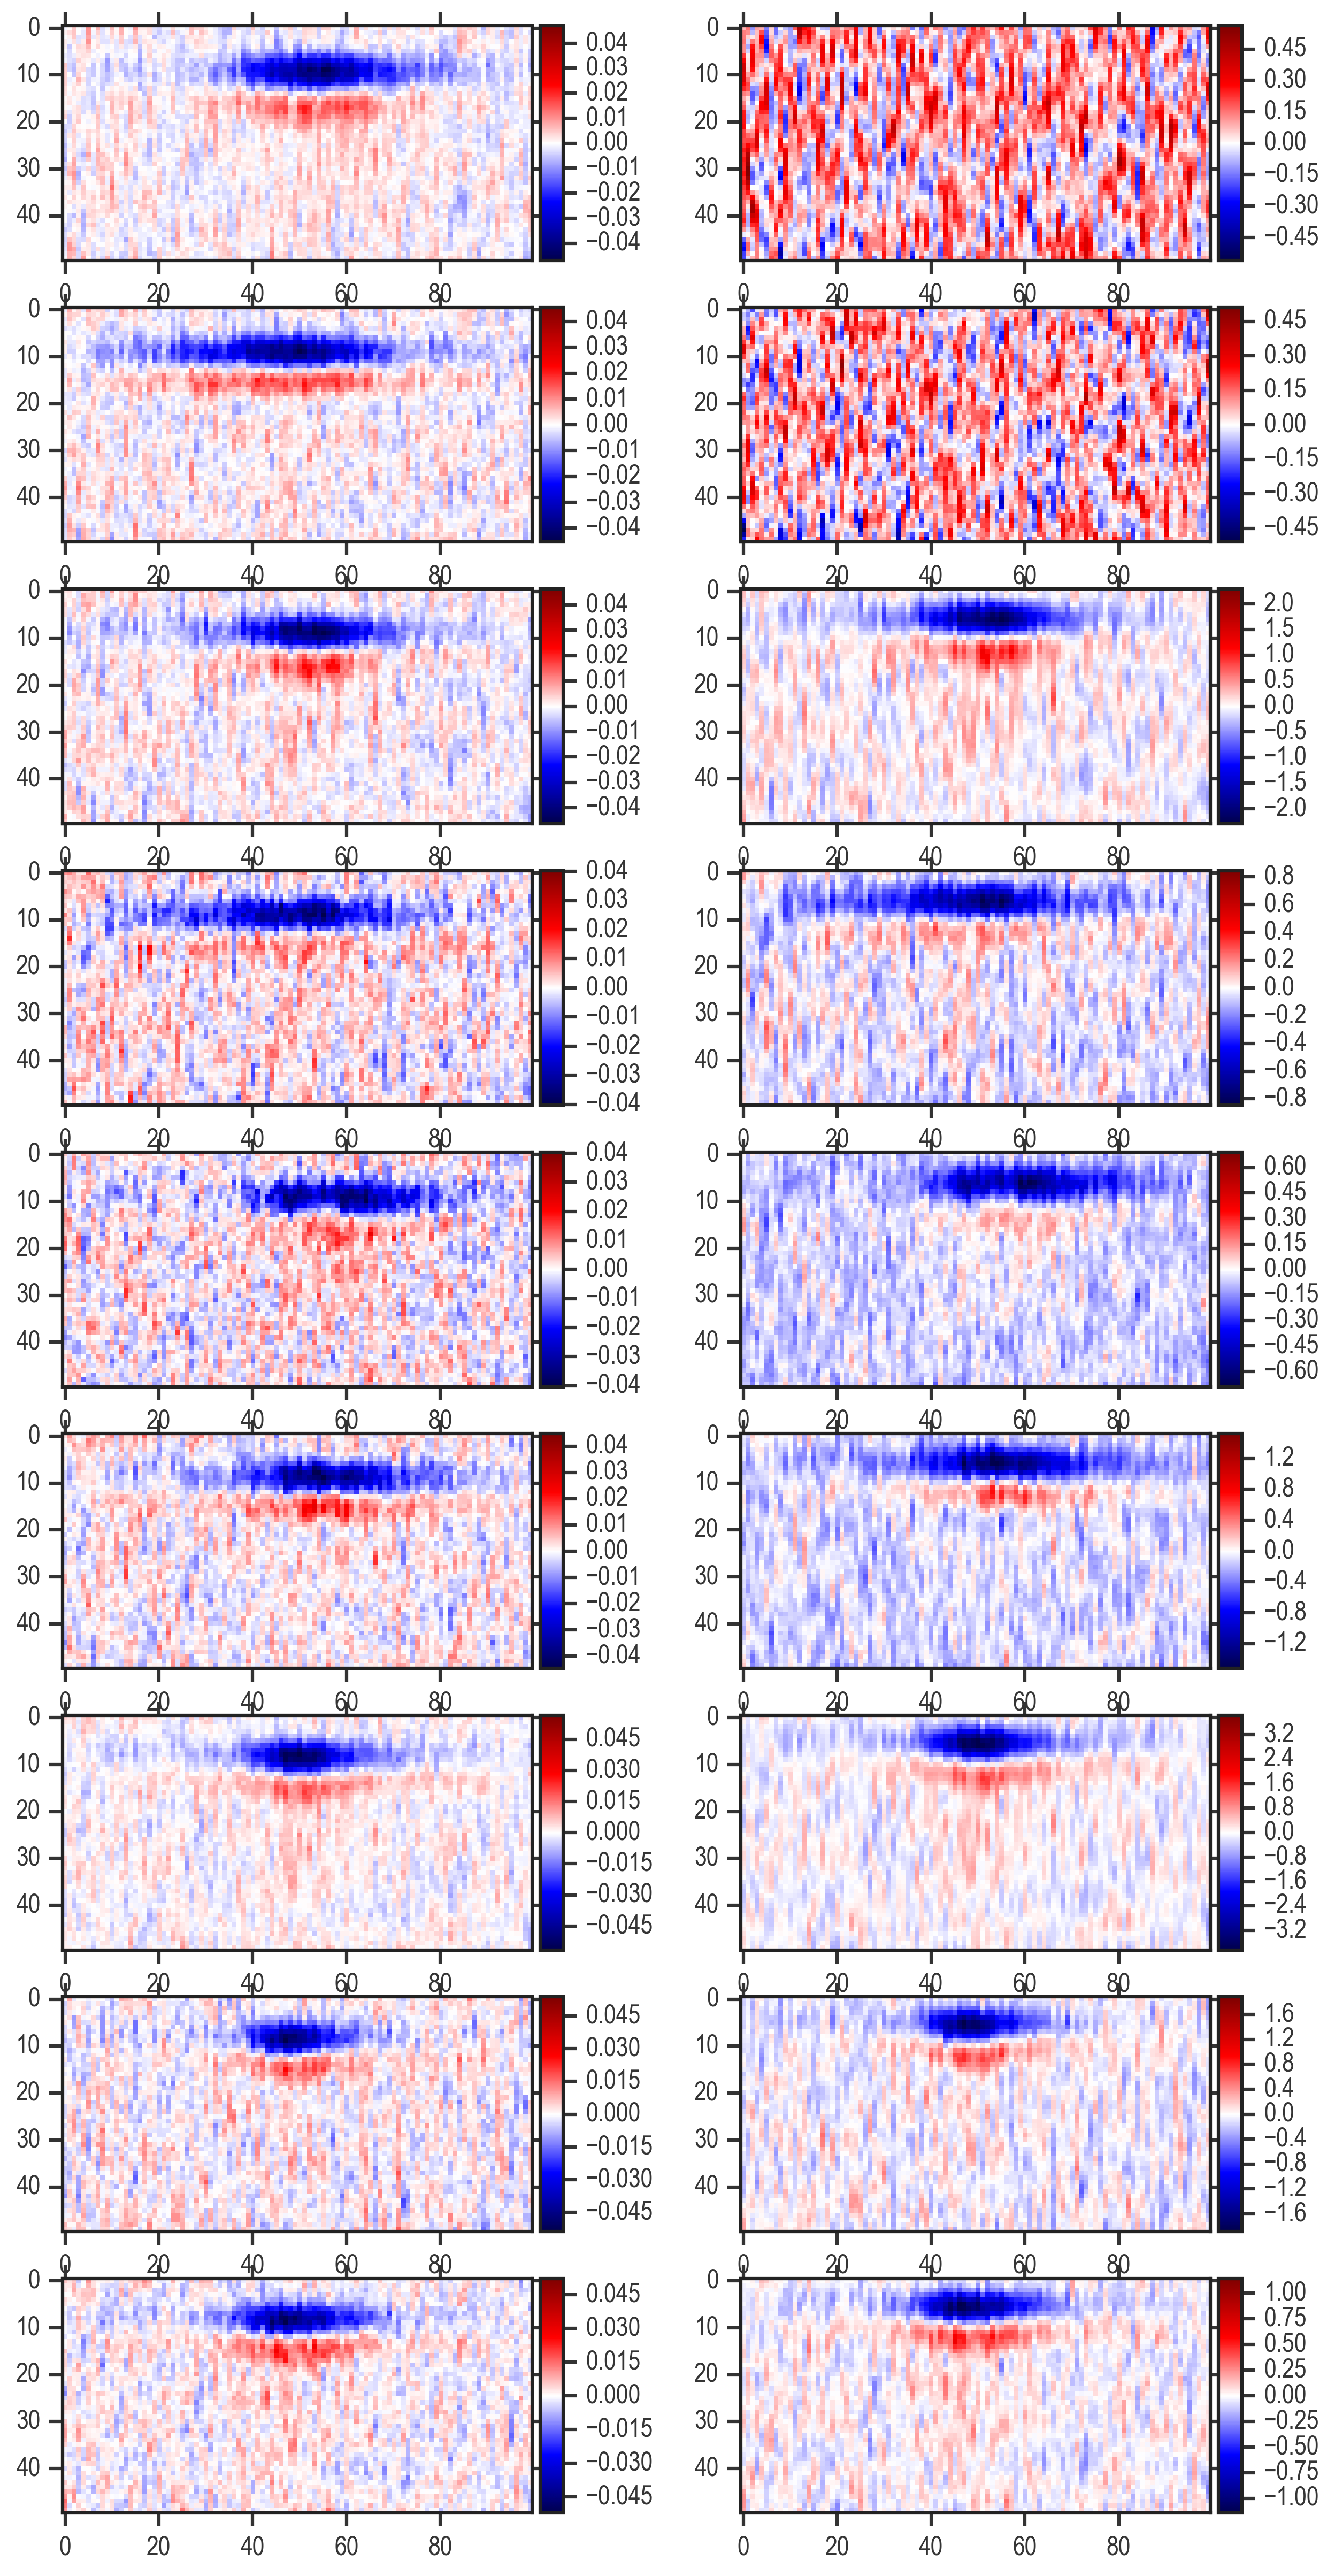

In [81]:
fig = plt.gcf()
fig.set_size_inches((10,20))
num_expts = len(h_rfs.keys())
for ide, expt in enumerate(sorted(h_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(h_rfs[expt], clim=[-np.max(abs(h_rfs[expt])), np.max(abs(h_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(h_recreated_rfs[expt], clim=[-np.max(abs(h_recreated_rfs[expt])),
                                                           np.max(abs(h_recreated_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

In [87]:
receptive_fields = collections.defaultdict(list)
for expt in sorted(h_rfs.keys()):
    rf = h_rfs[expt]
    pca = PCA(n_components=2)
    pca.fit(rf)
    g_pca = pca.components_[0]

    sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
    receptive_fields['horizontal'].append(sign_of_pc * g_pca)

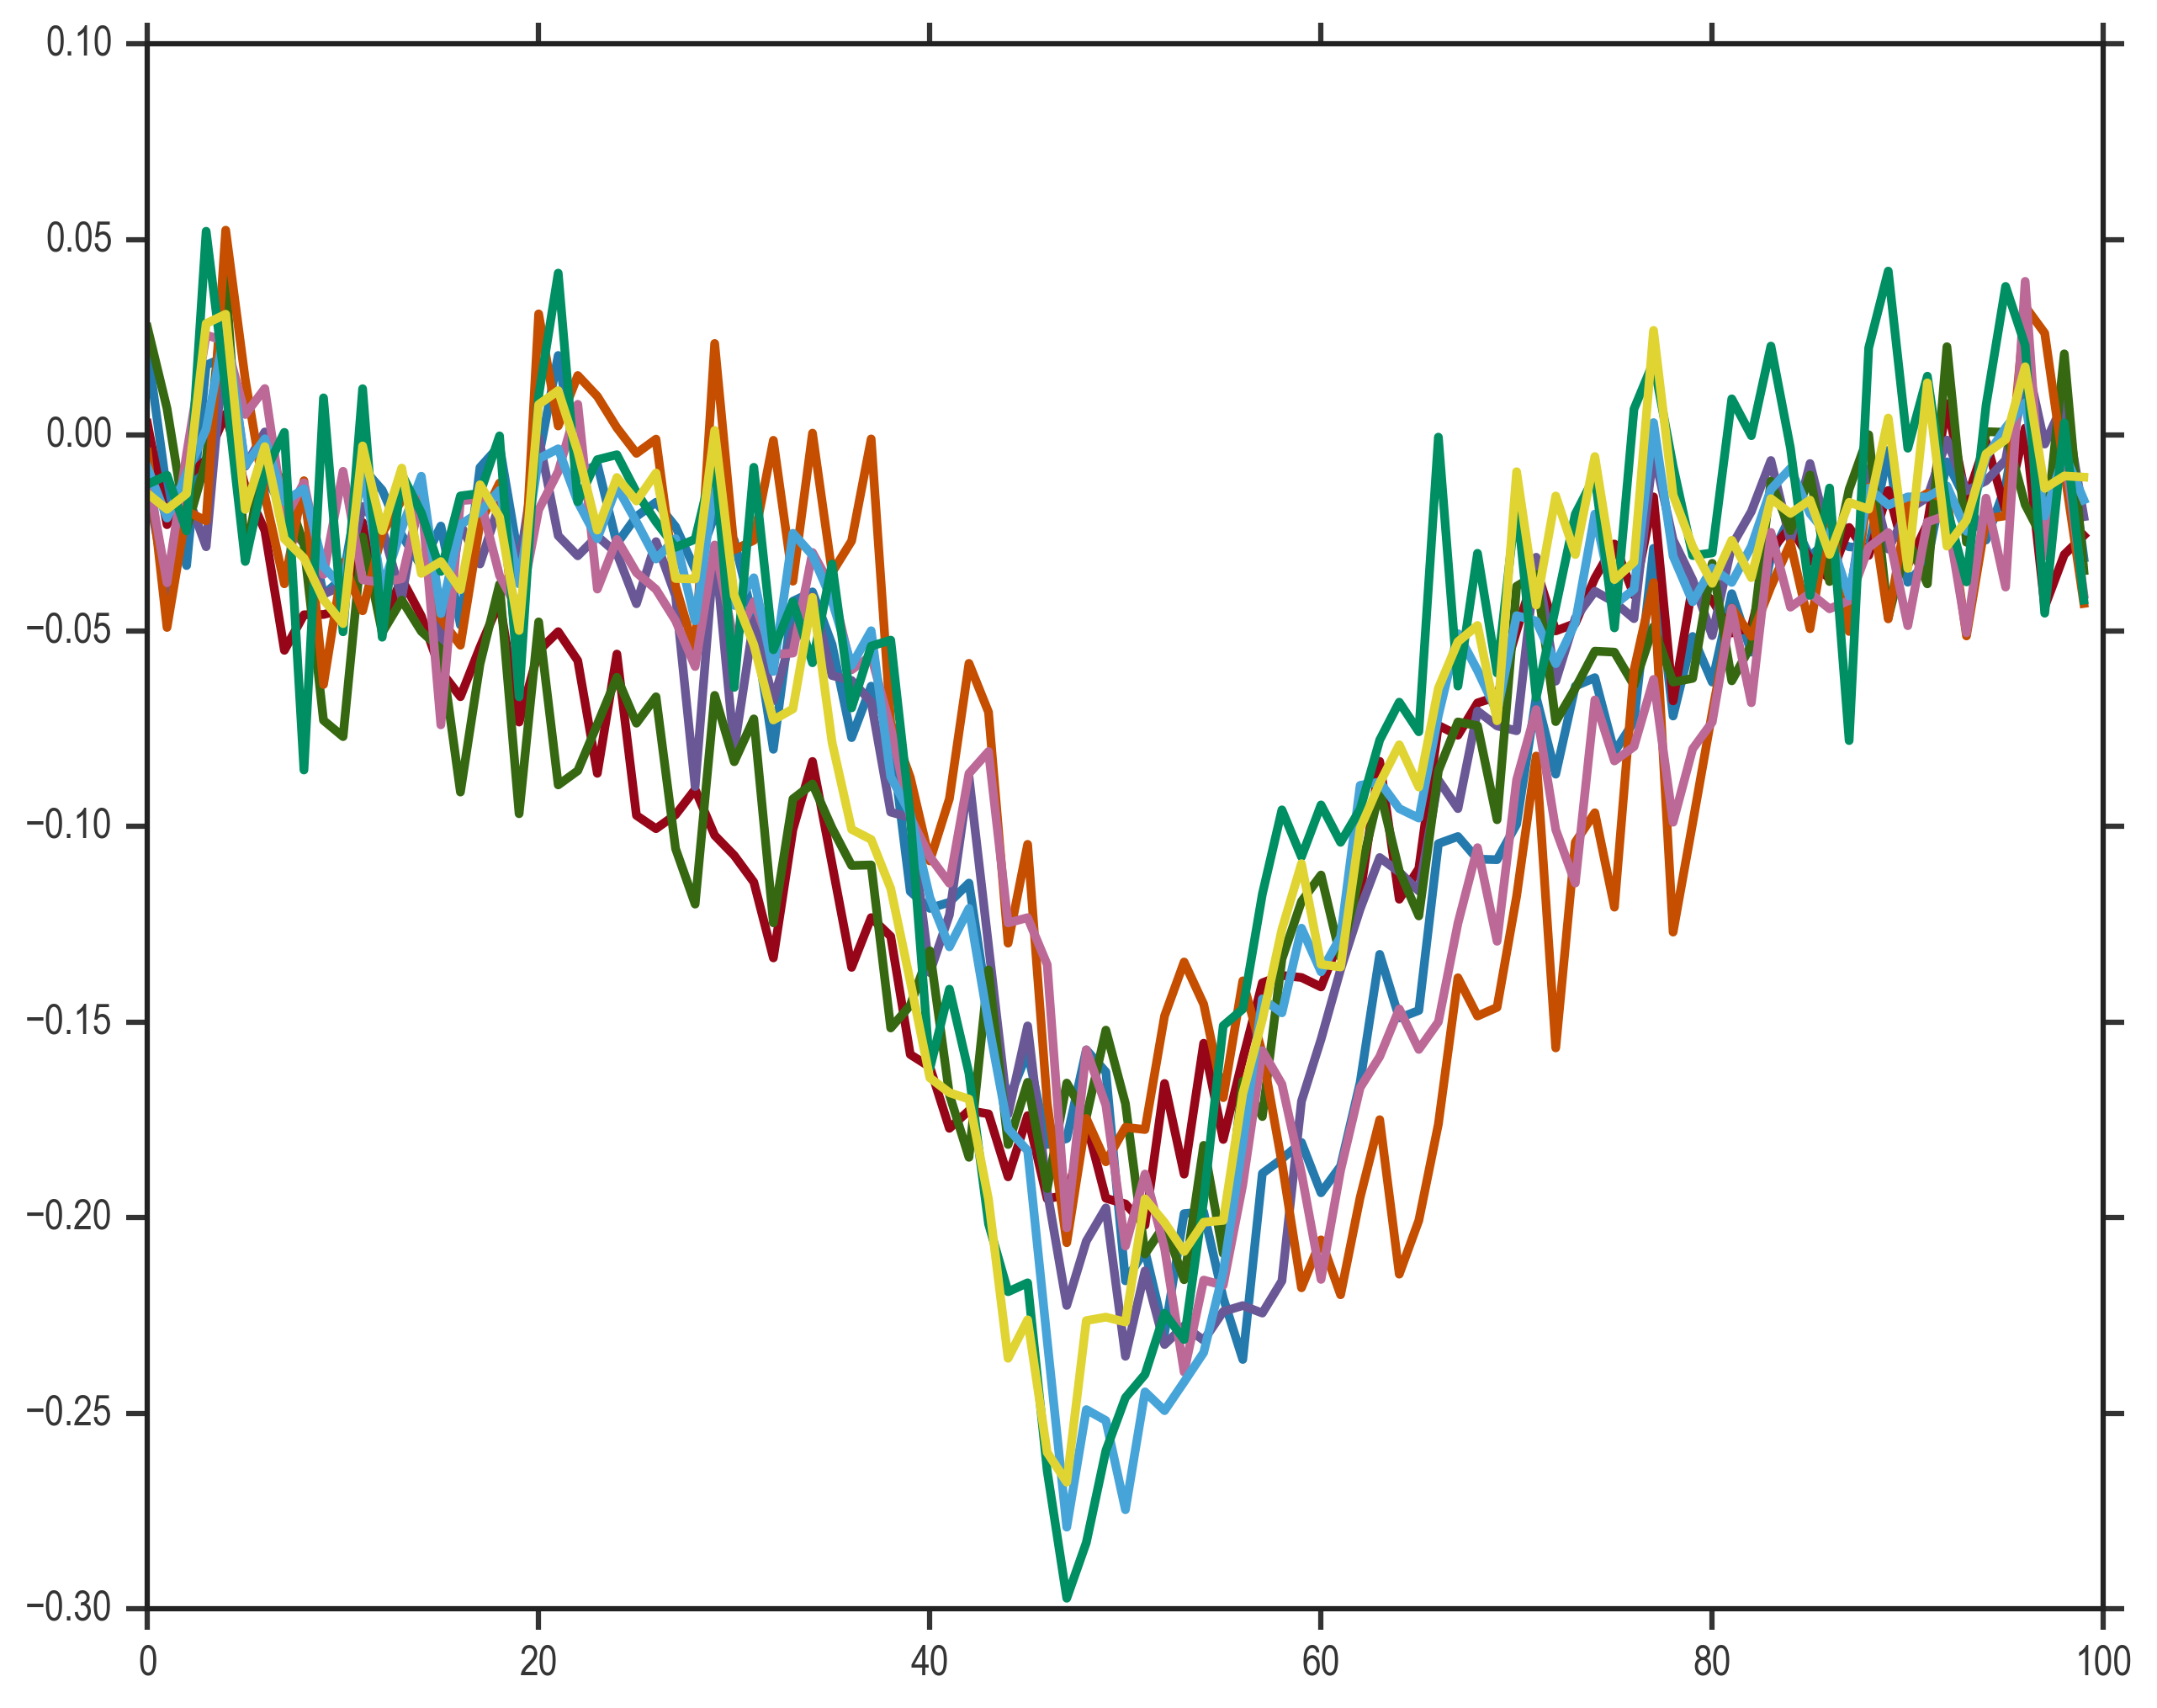

In [90]:
for rf in receptive_fields['horizontal']:
    plt.plot(rf)

# Amacrine cells

In [75]:
a_rfs = collections.defaultdict(list)
a_recreated_rfs = collections.defaultdict(list)
with h5py.File(data_dir + a_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        a_rfs[expt] = np.array(f['lines/rfs/%s' %expt])
        detrended_mem_pot = np.array(f['lines/detrended_membrane_potential'])[ide]
        stimuli = np.array(f['lines/stimuli'])
        a_recreated_rf = np.zeros_like(a_rfs[expt])
        window_size = a_rfs[expt].shape[0]
        for t in range(window_size, len(detrended_mem_pot)):
            a_recreated_rf += stimuli[(t-window_size):t].astype('float') * detrended_mem_pot[t]
        a_recreated_rf /= (len(detrended_mem_pot) - window_size)
        a_recreated_rfs[expt] = a_recreated_rf[::-1]

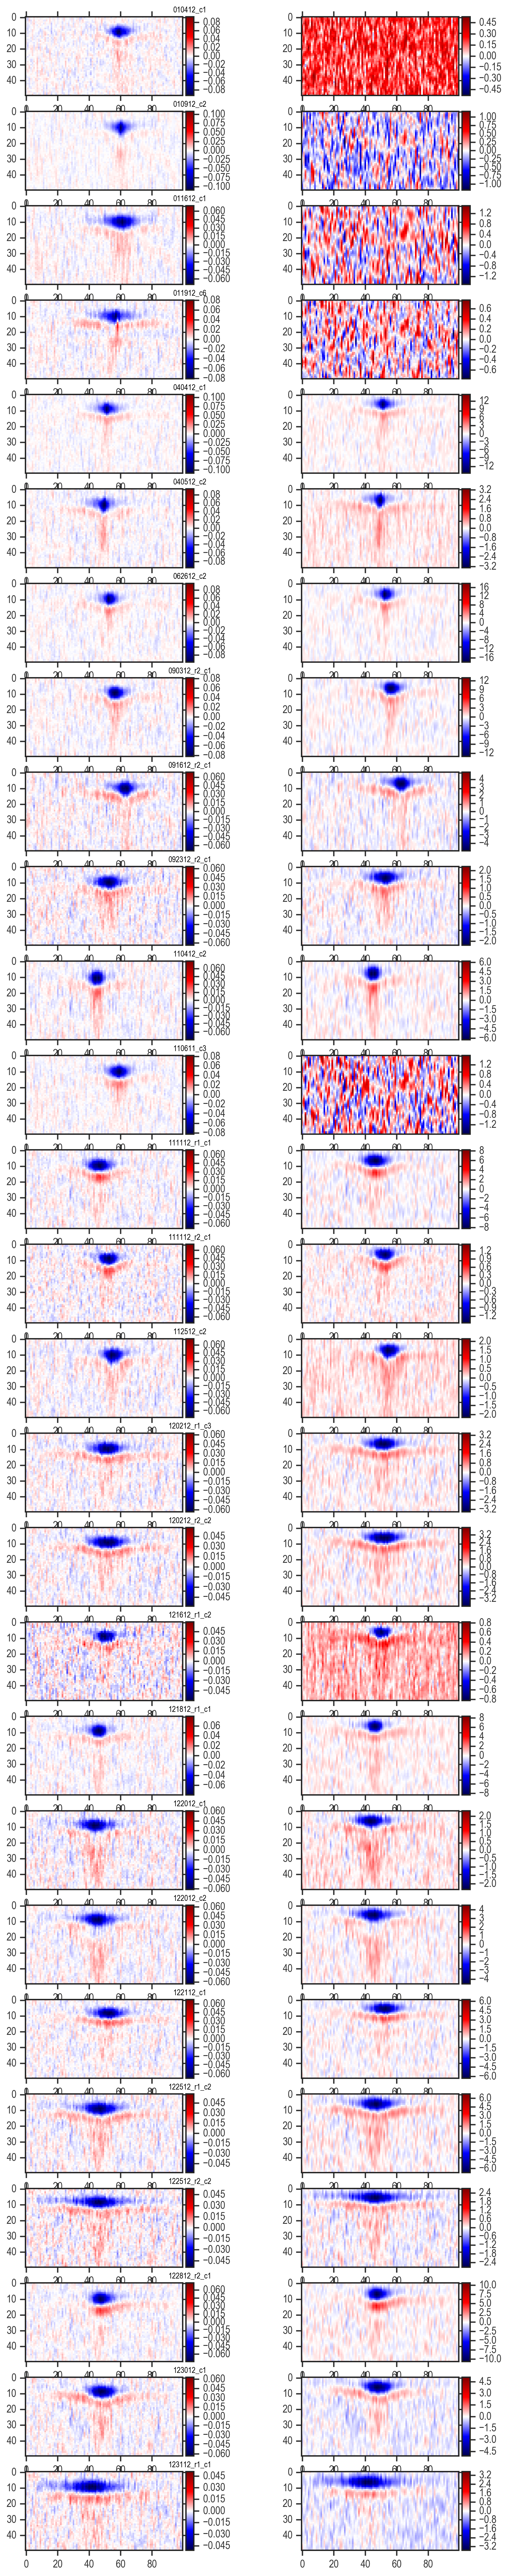

In [78]:
fig = plt.gcf()
fig.set_size_inches((10,50))
num_expts = len(a_rfs.keys())
for ide, expt in enumerate(sorted(a_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(a_rfs[expt], clim=[-np.max(abs(a_rfs[expt])), np.max(abs(a_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.title(expt, fontsize=9)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(a_recreated_rfs[expt], clim=[-np.max(abs(a_recreated_rfs[expt])),
                                                           np.max(abs(a_recreated_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

In [88]:
for expt in sorted(a_rfs.keys()):
    rf = a_rfs[expt]
    pca = PCA(n_components=2)
    pca.fit(rf)
    g_pca = pca.components_[0]

    sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
    receptive_fields['amacrine'].append(sign_of_pc * g_pca)

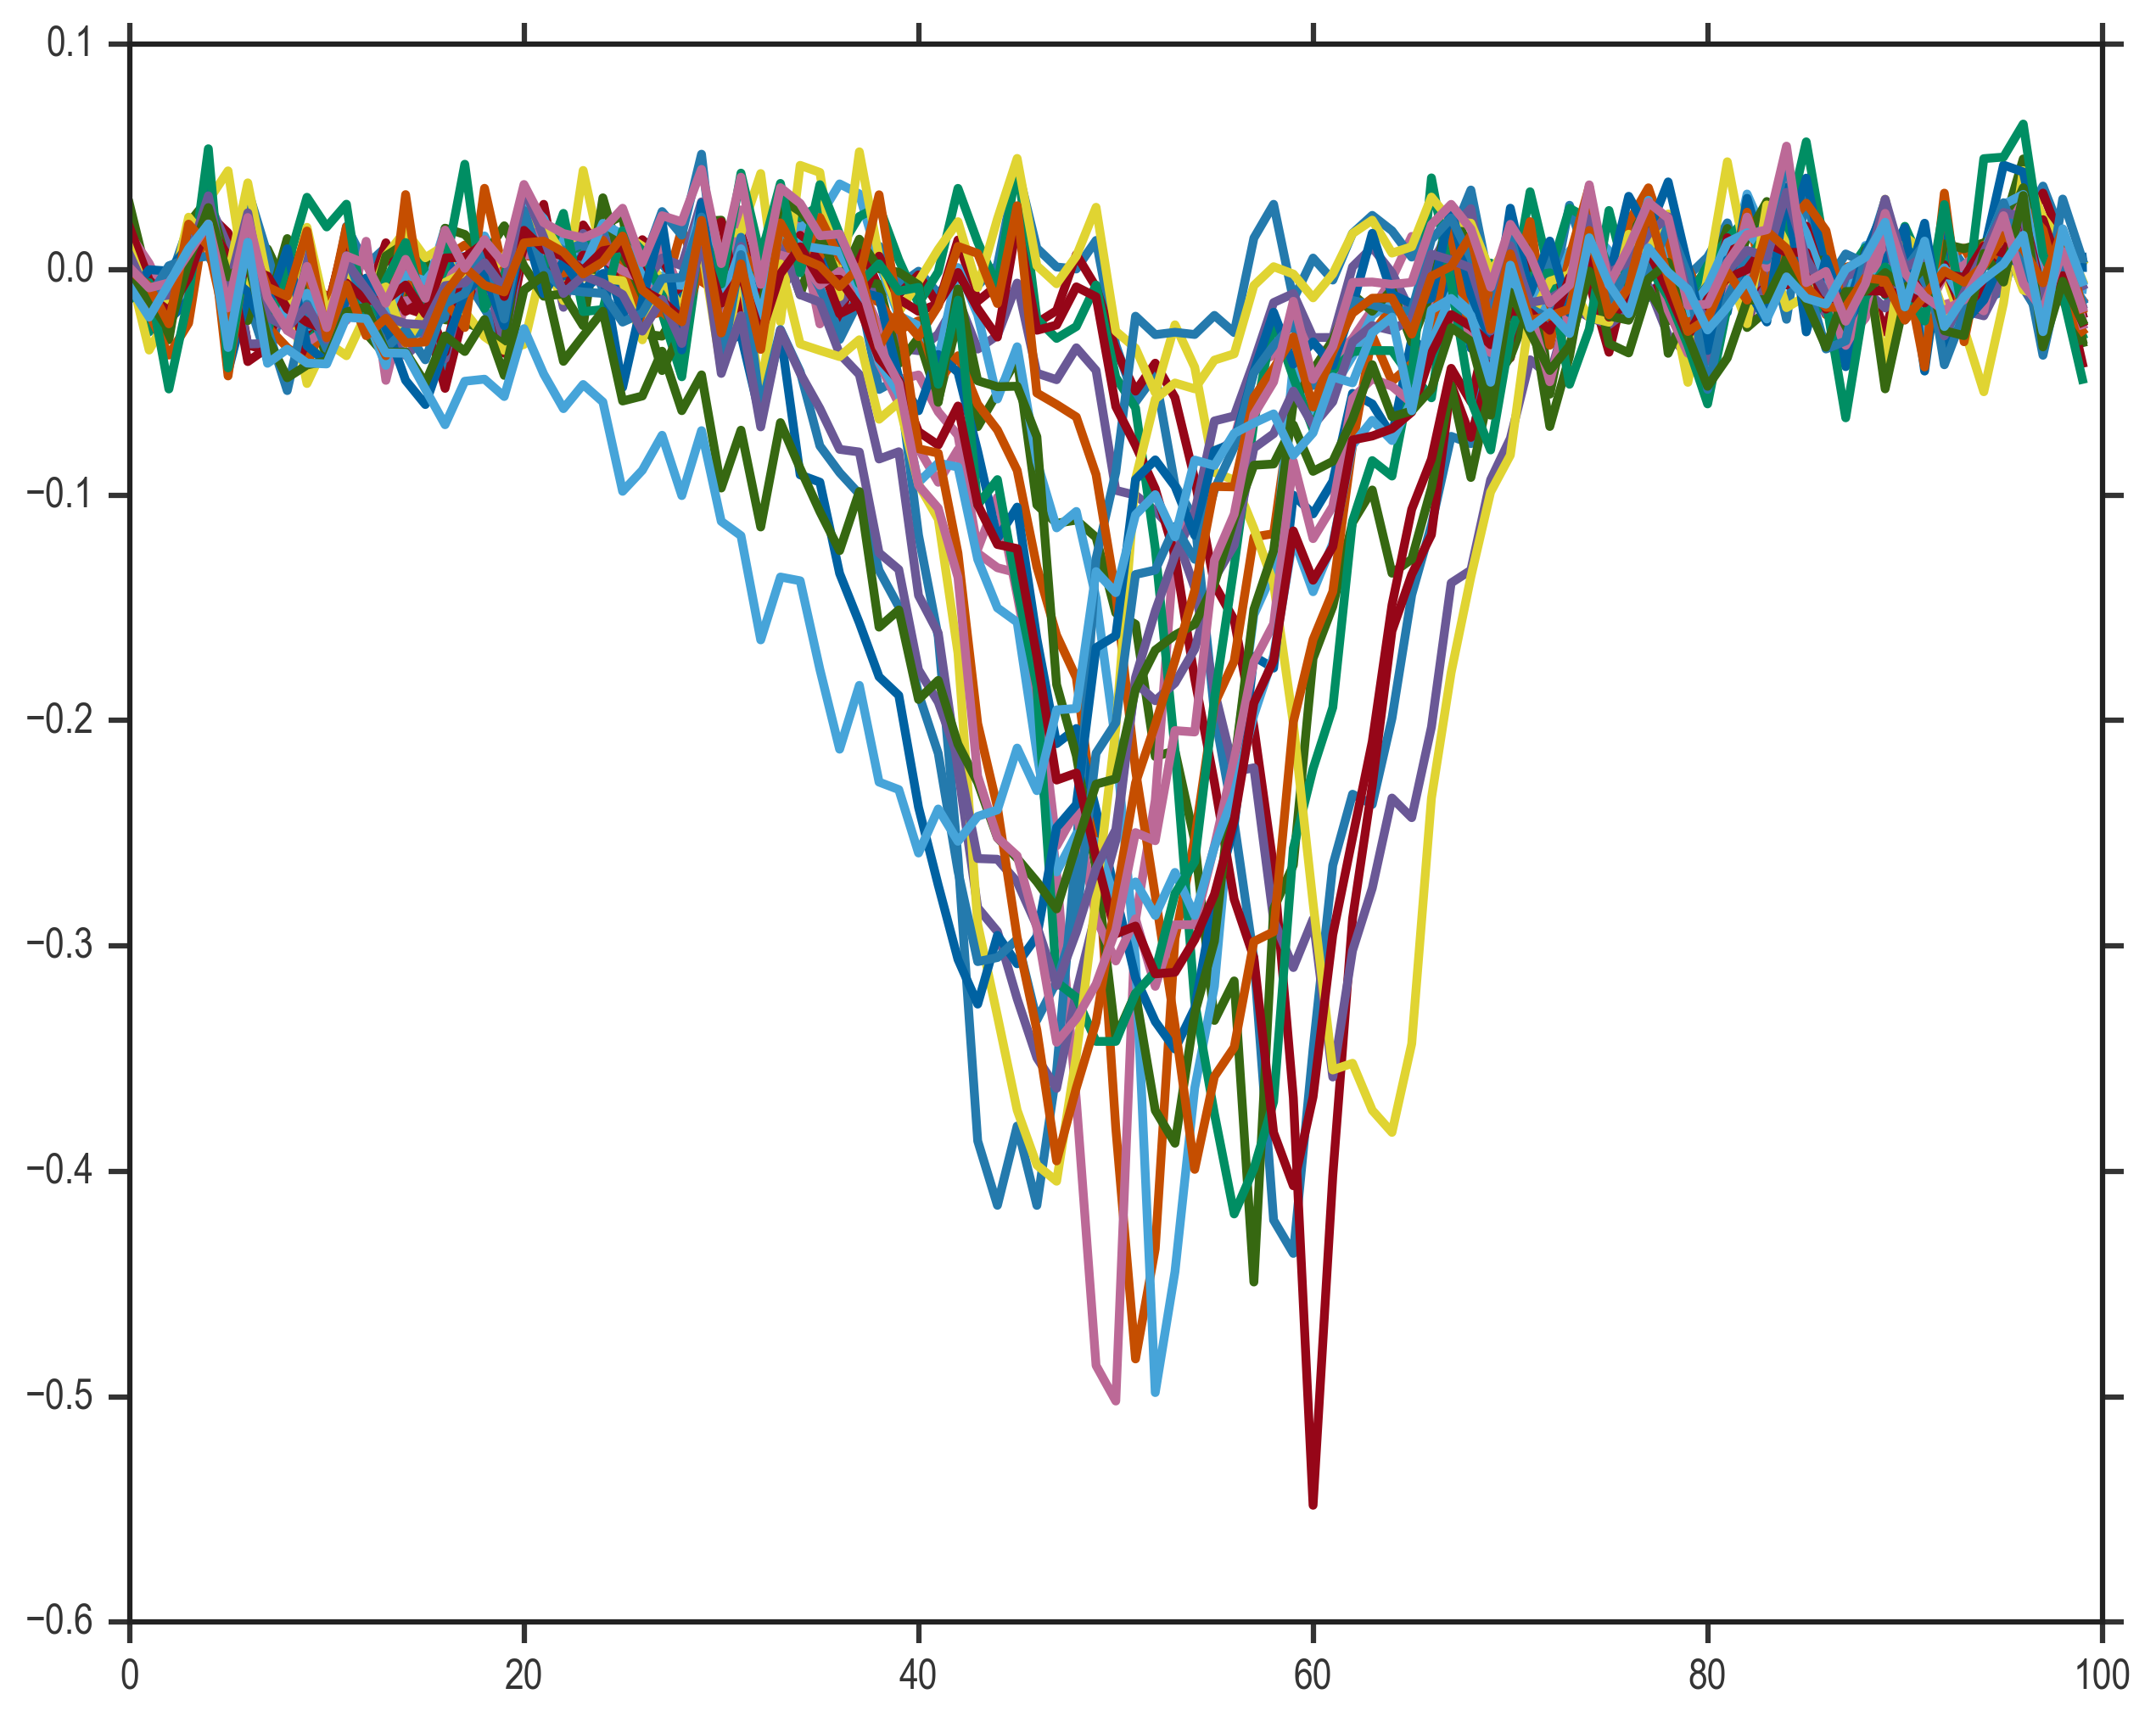

In [89]:
for rf in receptive_fields['amacrine']:
    plt.plot(rf)